# Image Processing, Part II

## Convolution and the Point Spread Function

We've frequently talked about how astronomical images are "blurred" or "smeared" or "have limited resolution" due to the atmosphere and/or the optics.  It's time to make that more mathematically precise.

Let's use $G(x,y)$ to refer to the flux distribution on the "true" sky: this is a continuous function, and it's what we'd see if we had a telescope with perfect resolution and infinitely tiny pixels.  Then the image we *actually* see is:

$$I(x,y) = (T \ast G)(x,y)$$

$T(x,y)$ is called the *Point Spread Function* or *PSF*, and the operator $\ast$ is a *convolution*; it's shorthand for this integral:

$$I(x,y) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} T(u,v)\;G(u-x,v-y)\;du\;dv$$

It's easiest to think about convolution geometrically, and we'll start in one dimension.

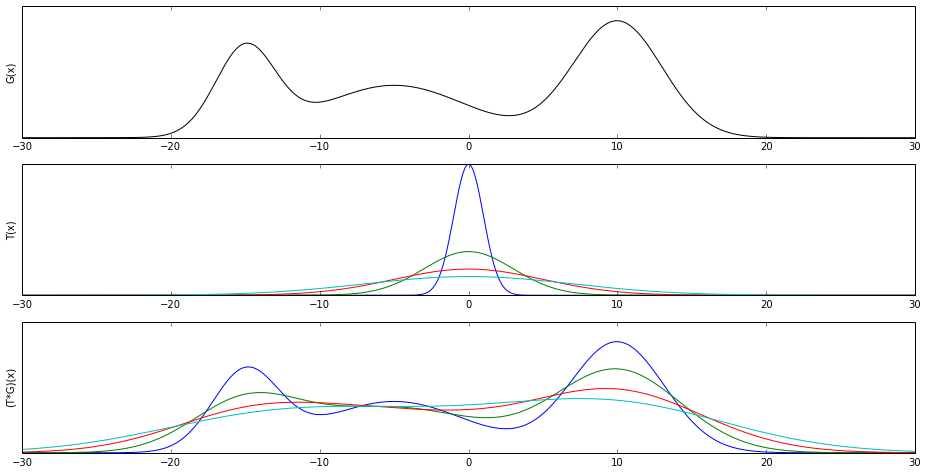

In [28]:
import day8funcs
%matplotlib inline
day8funcs.plot1d()

Here's one way to think of it: the convolution of $T$ and $G$ is result of putting a copy of $T$ at every $x$ point, scaled by the value of $G$ at that value of $x$, then adding up all of those copies of $T$.

In the example (and the math) above, the PSF $T$ is constant over the region we convolve.  On large astronomical images, that's not the case.  In other words, in the convolution integral above, $T$ isn't just a function of the $(u,v)$ variables we're integrating over, it's also a function of $x$ and $y$:

$$I(x,y) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} T(u,v,x,y)\;G(u-x,v-y)\;du\;dv$$

However, $T$ changes very little with $x$ and $y$, and it's almost always safe to consider it constant over small parts of an image (like the `hsc-image-small.fits` image we've been working with).

How would the PSF affect the moments-based measurements we implemented yesterday?
 - Fluxes (zeroth moments)

* * Assuming PSFs are normalized to 1, the total flux must should be the same. Some of the light might now fall outside your aperture, and some light from outside might fall inside, though.

 - Centroids (first moments)

* * If your PSF has zero centroid itself, these shouldn't change, assuming an unweighted centroid measurement. For nontrivial weighting functions, the PSF being symmetric means it shouldn't affect the centroid.

 - Shapes (second moments)

* * Second moments will be increased. For a gaussian-shaped object, the new sigmas will be &radic;(&sigma;<sub>PSF</sub><sup>2</sup> + &sigma;<sub>object</sub><sup>2</sup>). You can add unweighted moments in quadrature (symbolically seen earlier) to get what you expect from a convolution.

Because the PSF is potentially different for every exposure, correcting for its effects is one of the most important parts of astronomical image processing.  Usually that involves creating a model of the PSF.  What sources of information could we use to constrain the PSF model?

* * Known good stars - watch out for resolved objects e.g. binaries and galaxies
* * Stars must have high enough brightness for SNR
* * Laser guide stars
* * The optical design should inform a first guess at PSF.

## Coordinate Systems

Convolution with the PSF isn't the only thing that affects the signal we see - there's also a coordinate transformation from angular coordinates on the sky to pixel coordinates, which we can write like this:

$$x, y = S(\alpha, \delta)$$

$\alpha$ and $\delta$ are called "right ascension" and "declination", respectively, and they're essentially astronomical longitude and latitude, but fixed to points on the sky instead of points on earth.  Like latitude, declination is zero on the equator, and increase to the north and south.  These are also called "equatorail coordinates", because they're lined up with the earth's equator.  There are also "ecliptic coordinates" (oriented to the plane of the solar system) and "galactic coordinates" (oriented to the plane of the Milky Way), and even coordinates aligned to structures larger than the galaxy.  But equatorial coordinates are by far the most common.  All of these systems are generally refererred to as "WCS" for "world coordinate system", especially when differentiating between these angular coordinates and pixel coordinates.

Confusingly, we also use "WCS" to refer to the *transformation* between angular coordinates like these and pixel coordinates (called $S$, above).  Most astronomical images are in what's called a [gnomonic projection](https://en.wikipedia.org/wiki/Gnomonic_projection) - you can look up the details yourself if you like, but it's most important for our purposes to know that there's essentially no distortion due to this projection in most astronomical images, simply because most images (at least from optical telescopes) cover a very small area of the sky; even LSST's enormous field of view is only 10 square degrees (~3 degrees on a side).

However, map projections aren't the only things that go into the transformation from angular coordinates to pixels.  There also usually distortions due to the optics, and, in some cases, due to curved electrical field lines in the detectors (after all, pixels positions are just defined by the electric fields that hold charge in place).  On the small scale of most astronomical images, these matter more than the projection.

While it's not usually as difficult to get right as the PSF, creating a model for the transformation from angular coordinates to pixel coordinates is also extremely important.  What sources of information could we use to constrain the WCS model?

## Pixel Noise

What is the probability $P(n|v,t)$ of detecting $n$ photons in a particular pixel, from an astronomical source that emits $v$ photons per second in the angular area covered by the pixel, if we have an exposure time of $t$ seconds?

How would this change if we also expected to get $b$ photons per second in that pixel from the sky background?

As the number of photons detected gets very large, the distribution we're using becomes very similar to another distribution function.  Write the down the probability in terms of that other distribution function.

It turns out there's another source of noise, from the electronics when we try to turn the number of electrons in a pixel into a digital signal; we call this "read noise".  Let's say that it's Gaussian-distributed, with a standard deviation of $\sigma_r$ (and a mean of $0$).  What are the mean and variance of the probability distribution now?

Let's now assume that we've subtracted the background, and we've done it *perfectly*.  How does that affect the probability distribution?

The signal-to-noise ratio (SNR) in a pixel is given by the *expected* signal, divided by the square root of the variance.  What is the "signal" in this case?  Write down the SNR.

How does the SNR scale with exposure time when the exposure time is very short?  What about when it's very long?

## Model-Fitting

The variance (we've computed here is exactly what is saved in the HDU 1 of the `hsc-image-small.fits` (the units may not be electrons anymore, but that's just a constant scaling that's applied to both the variance and the data image).  Let's call that $\sigma_{x,y}$.  Similarly, the data image contains $n_{x,y}$, the number of photons we actually got in each pixel (or, rather, something proportional to it, given the change in units).

Now, let's imagine we have a model $f(x,y|\theta)$ that predicts the number of photons from an astronomical source that would land in each pixel (i.e. it predicts $(v\,t)$ for pixel $x,y$).  Write down the likelihood $P(n_{x,y}|\theta,\sigma_{x,y})$ for a *single pixel*.  That's the probability of getting $n_{x,y}$ photons in the pixel at $x,y$ given the model $f(\theta)$ and variance $\sigma_{x,y}^2$.

Now write down the total likelihood $P(n|\theta,\sigma)$ - the probability of getting all of the all of the data values we actually have in the image simultaneously, given the parameters $\theta$ and all the variance values $\sigma^2$.  Take the log of this to get the log likelihood.  You should get something very familiar.